This notebook compares the histograms of salinity and temperature gradients in eORCA025 data and its coarsed versions. The histograms are compared with the use of 4 different definitions of distances between distributions. The coarsed data is also compared with coarsed and interpolated (regridded back ro 0.25 grad) data.

In [1]:
!pip install gcm-filters -q

# Dask start

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:35453")
client

<Client: 'tcp://127.0.0.1:35453' processes=4 threads=8, memory=29.40 GiB>

# Import

In [3]:
#import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import gsw
import gcm_filters
from xhistogram.xarray import histogram
import eos_module
from dask import compute
from dask.diagnostics import ProgressBar
from dask import delayed
import pandas as pd
import cartopy.crs as ccrs
from scipy.stats import kurtosis, skew, describe
from scipy import ndimage
from numpy.polynomial import polynomial as P
import xrft
#import xrft_module
import xesmf as xe

In [4]:
# import importlib
# importlib.reload(xrft)

# Plotting params

In [5]:
#%matplotlib widget
%matplotlib inline

In [6]:
line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4']

In [7]:
cmaps_list = ['Blues', 'Oranges', 'Greens', 'Reds']

# Load data

Choose cases

In [8]:
data=[dict() for i in range(6)]

In [9]:
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR wint'})
data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR sum'})
data[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'AÇORES wint'})
data[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'AÇORES sum'})
data[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED wint'})
data[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED sum'})

In [10]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,250),y=y_slice,x=x_slice) 
coord_slice = dict(y=y_slice,x=x_slice)

In [11]:
nb_of_time_chunks = 4

## eORCA025

In [12]:
for i in range(len(data)) :
    data[i]['LR'] = xr.open_mfdataset("Data/eORCA025/region"+data[i]['region']+"_"+data[i]['season']+".nc").\
    rename(nav_lat='lat', nav_lon='lon')
    data[i]['LR'] = data[i]['LR'].drop(['time_centered_bounds', 'time_counter_bounds', 'sossheig', 'gradx_temp', 'grady_temp', 'gradx_sal', 'grady_sal',\
                                       'grad_temp', 'grad_sal'])

## Plot snapshots

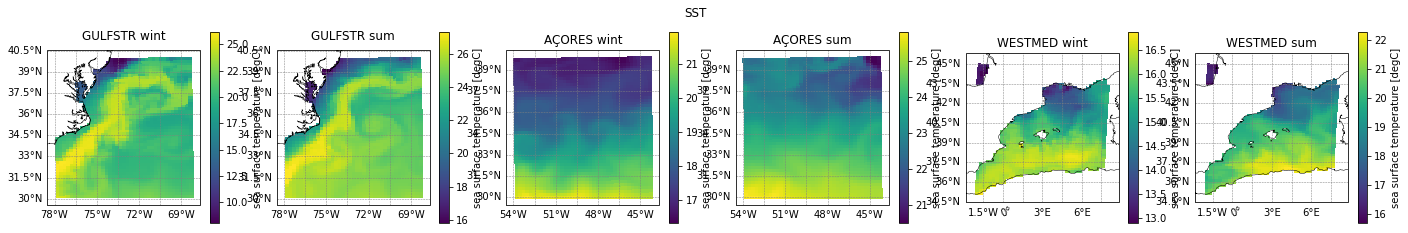

In [13]:
fig, axis = plt.subplots(ncols=len(data), nrows=1, figsize=(24,3.5), squeeze=False, subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('SST')
for col in range(len(data)) :
    for row, dataSetKey in enumerate(['LR']) :
        data[col][dataSetKey].isel(time_counter=-1).sosstsst[coord_slice].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=data[col]['label'])

for ax in axis.flatten() :
    ax.coastlines(color='k', lw=0.5)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False

# Density

Compute conservative temperature and density anomaly $\sigma_0$ with the use of `gsw` library:

In [14]:
%%time
for i in range(len(data)) :
    for dataKey in ['LR'] :
        data[i][dataKey]['CT'] = xr.apply_ufunc(gsw.conversions.CT_from_pt, data[i][dataKey]['sosaline'], data[i][dataKey]['sosstsst'], dask='parallelized').compute()
        data[i][dataKey]['sigma0_true'] = xr.apply_ufunc(gsw.density.sigma0, data[i][dataKey]['sosaline'], data[i][dataKey]['CT'], dask='parallelized').compute()
        data[i][dataKey]['CT_sqr'] = data[i][dataKey]['CT']**2

CPU times: user 204 ms, sys: 31.8 ms, total: 236 ms
Wall time: 668 ms


# Coarsening from 0.25°

## Routines

In [15]:
def downsample(data, window_size, area_2d, wet_mask) :
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*data
    data_weighted_sums = data_weighted.coarsen(x=window_size, y=window_size, boundary='trim', \
                                           coord_func={'x':'mean', 'y':'mean', 'lat':'mean', 'lon':'mean'}).sum(skipna=True)
    area_window_sums = area_masked.coarsen(x=window_size, y=window_size, boundary='trim').sum(skipna=True)
    result = data_weighted_sums/area_window_sums
    result['x'] = np.arange(len(result['x']))
    result['y'] = np.arange(len(result['y']))
    
    # coarsened coordinates:
    new_e1t = data['e1t'].coarsen(x=window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'],errors='ignore')
    new_e2t = data['e2t'].coarsen(x=window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'],errors='ignore')
    result['e1t'] = (['y','x'], new_e1t.values) 
    result['e2t'] = (['y','x'], new_e2t.values) 
    
    # binarize and erode the mask (to remove isolated pixels)
    #threshold = 0.9
    #new_wetmask = ndimage.binary_erosion(np.where((result['tmask'] > threshold), 1.0, 0.0))
    #result['tmask'] = (['y','x'], new_wetmask.astype(np.float32))
    # apply new mask to data
    #result = result.where(result.tmask>0)
    return result

In [16]:
def apply_filter_downsample(dataHR, filter_coef, coarse_window_size) :
    wet_mask = xr.DataArray(dataHR.tmask, dims=['y','x'])
    area = xr.DataArray((dataHR.e1t * dataHR.e2t), dims=['y','x'])
    if (filter_coef > 0) :
        # Filtering with a fixed factor
        dxw = xr.DataArray(dataHR.e1u, dims=['y','x']) # x-spacing centered at western cell edge
        dyw = xr.DataArray(dataHR.e2u, dims=['y','x']) # y-spacing centered at western cell edge
        dxs = xr.DataArray(dataHR.e1v, dims=['y','x']) # x-spacing centered at southern cell edge
        dys = xr.DataArray(dataHR.e2v, dims=['y','x']) # y-spacing centered at southern cell edge
        dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min()).values
        dx_max = max(dxw.max(),dys.max()).values
        filter_scale = filter_coef*dx_max
#         kappa_w = xr.ones_like(dxw)
#         kappa_s = xr.ones_like(dxw)
        kappa_w = dxw * dxw / (dx_max * dx_max)
        kappa_s = dys * dys / (dx_max * dx_max)
        # define the filter
        gaussian_filter = gcm_filters.Filter(
            n_iterations=2,
            filter_scale=filter_scale,    
             dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s} )
        # apply filter to HR data
        data_filtered = xr.Dataset({}, coords=dataHR.coords)
        data_filtered = gaussian_filter.apply(dataHR, dims=['y', 'x'])
    else :
        data_filtered =  xr.Dataset({}, coords=dataHR.coords)
        data_filtered = dataHR
    # spatial coarsening
    if (coarse_window_size > 0) :
        dataLR = downsample(data_filtered, coarse_window_size, area, wet_mask)
    else : 
        dataLR = data_filtered
    return dataLR

## Set of transformations to compare

In [17]:
filters = [dict({'filter_coef' : 0, 'coarsening_window_size' : 2, 'label' : r'0.25° $\rightarrow$ 0.5°'}),
          dict({'filter_coef' : 0, 'coarsening_window_size' : 4, 'label' : r'0.25° $\rightarrow$ 1°'}),
          dict({'filter_coef' : 0, 'coarsening_window_size' : 8, 'label' : r'0.25° $\rightarrow$ 2°'})
          ]

In [18]:
%%time
for i in range(len(data)) : 
    data[i]['LR_mod'] = [] 
    for ifilter, curr_filter in enumerate(filters) :
        data[i]['LR_mod'].append(apply_filter_downsample(data[i]['LR'], curr_filter['filter_coef'], \
                                                         curr_filter['coarsening_window_size']))

CPU times: user 2.1 s, sys: 48.9 ms, total: 2.15 s
Wall time: 4.09 s


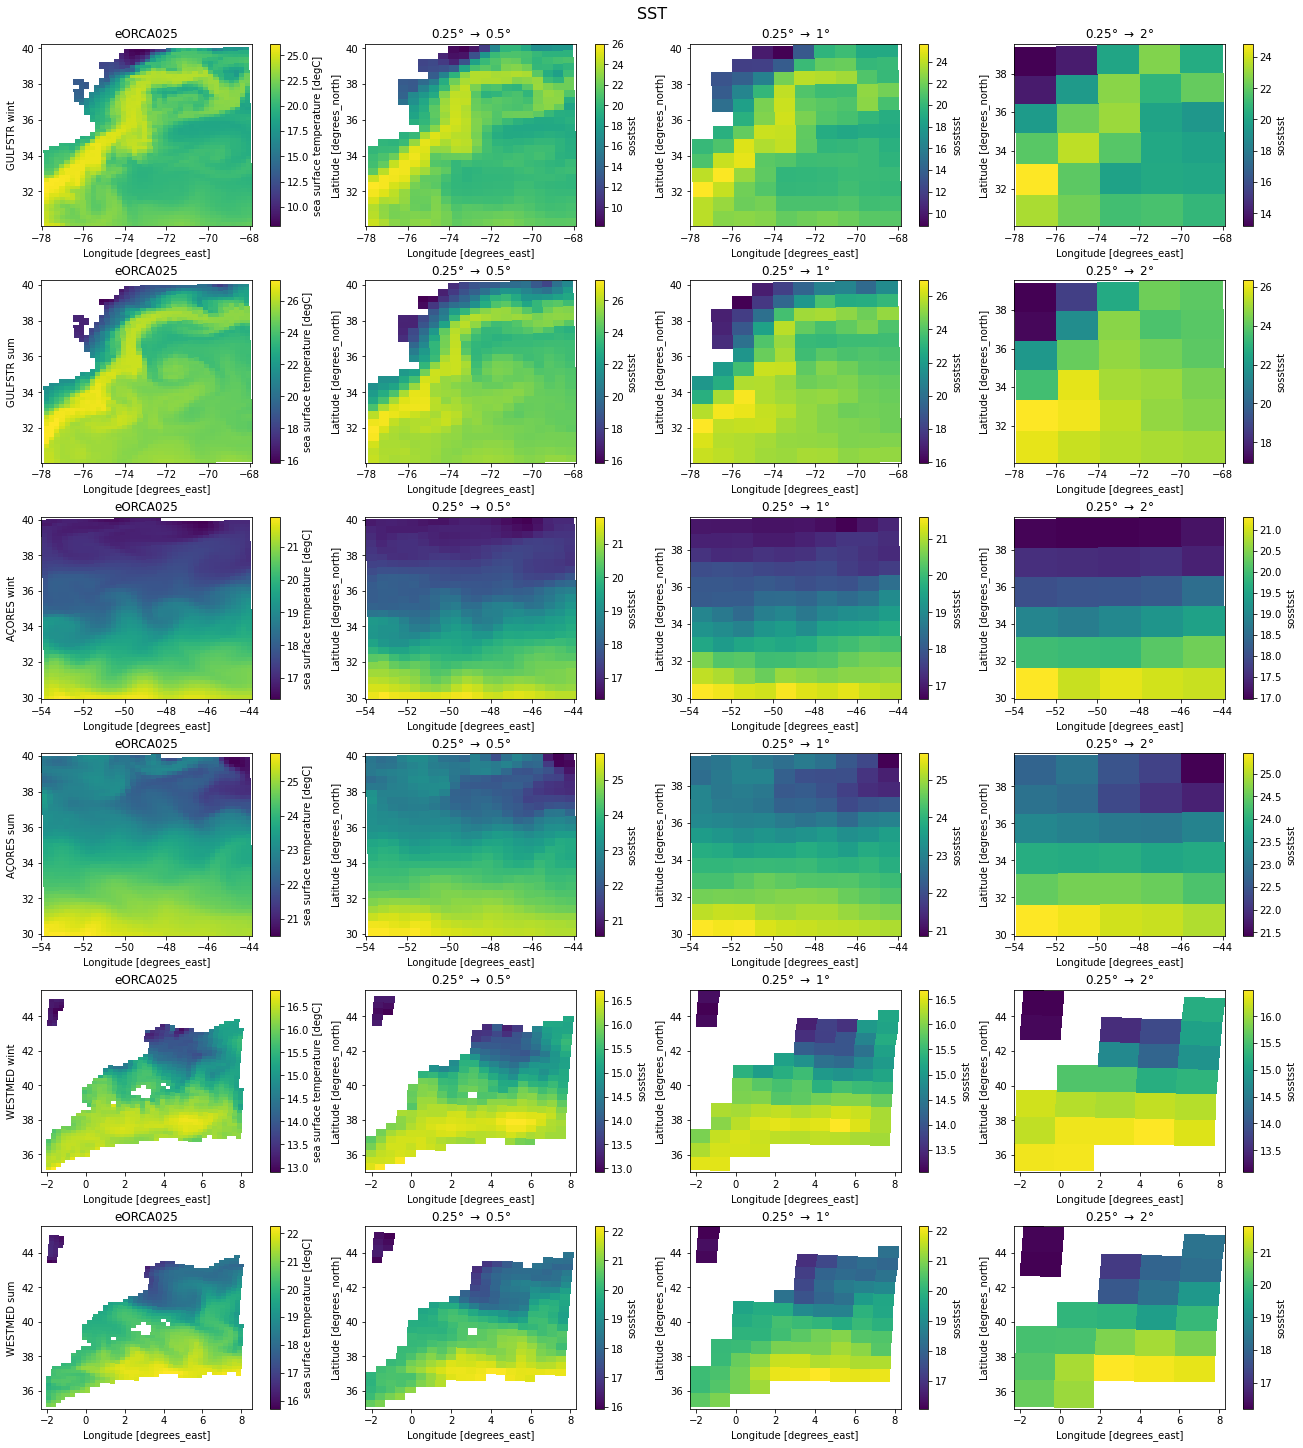

In [19]:
fig, axis = plt.subplots(ncols=4, nrows=6, figsize=(18,20), constrained_layout=True)
quantity='sosstsst'
fig.suptitle('SST', size=16)
for row in range(len(data)) :
    data[row]['LR'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,0])
    axis[row,0].set(title='eORCA025')
    for ifilter in range(len(filters)) :
        col = ifilter+1
        data[row]['LR_mod'][ifilter].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=filters[ifilter]['label'])
    axis[row,0].set(ylabel=data[row]['label'])

# Regridding onto original grid 0.25°

Method : bilinear interpolation

In [20]:
#regrid_method = "nearest_s2d"
regrid_method = "bilinear"

In [21]:
for i in range(len(data)) :
    data[i]['Regrid_LR_mod'] = [dict({'label' : filters[ifilter]['label'] +  r' $\rightarrow$ 0.5°'}) for ifilter in range(len(filters))] 

In [22]:
%%time
%%capture --no-display
for i in range(len(data)) :
    ref_data = data[i]['LR']
    out_grid = xr.DataArray(coords={'lon' : ref_data.lon, 'lat' : ref_data.lat, 'x': ref_data.x, 'y': ref_data.y}, \
            dims=['y', 'x'])
    #out_grid = data[i]['LR'].drop(['time_centered', 'depth', 'time_counter', 'e1t', 'e2t', 'e1f', 'e2f', 'e1v', 'e2v', 'e1u', 'e2u', 'nav_lat', 'nav_lon', 'tmask', 'sosstsst', 'sosaline'], error='ignore')
    for ifilter in range(len(filters)) :
        regridder = xe.Regridder(data[i]['LR_mod'][ifilter], out_grid, regrid_method, unmapped_to_nan=True)
        data[i]['Regrid_LR_mod'][ifilter] = regridder(data[i]['LR_mod'][ifilter])
        data[i]['Regrid_LR_mod'][ifilter].coords['e1t'] = ref_data.e1t
        data[i]['Regrid_LR_mod'][ifilter].coords['e2t'] = ref_data.e2t

CPU times: user 1.71 s, sys: 97.1 ms, total: 1.81 s
Wall time: 4.46 s


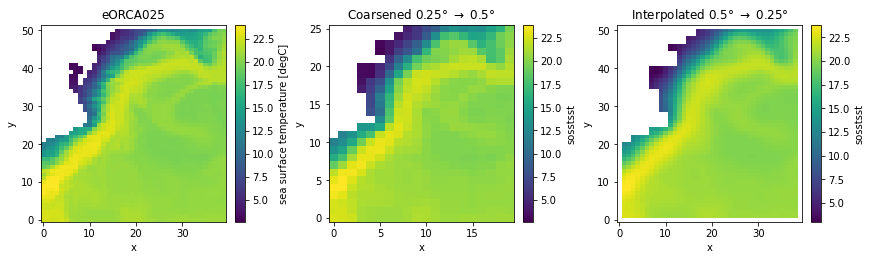

In [23]:
region=0
ifilter=0
fig, axis = plt.subplots(ncols=3, nrows=1, figsize=(12,3.5), constrained_layout=True)
data[region]['LR'].isel(time_counter=0).sosstsst.plot(ax=axis[0])
data[region]['LR_mod'][ifilter].isel(time_counter=0).sosstsst.plot(ax=axis[1])
data[region]['Regrid_LR_mod'][ifilter].isel(time_counter=0).sosstsst.plot(ax=axis[2])
axis[0].set(title='eORCA025')
axis[1].set(title='Coarsened '+filters[ifilter]['label'])
axis[2].set(title=r'Interpolated 0.5° $\rightarrow$ 0.25°')
plt.show()

# Histograms

## General routines

In [24]:
def compute_2D_histogram(dataSet, var1, var2, nb_of_bins, bins=None) :
    if bins is None :
        bins1 = np.linspace(dataSet[var1].min(), dataSet[var1].max(), nb_of_bins)
        bins2 = np.linspace(dataSet[var2].min(), dataSet[var2].max(), nb_of_bins)
    else :
        bins1 = bins[0]; bins2 = bins[1]
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum(skipna=True)).fillna(0.)
    hist = histogram(dataSet[var1].fillna(0), dataSet[var2].fillna(0), bins=[bins1, bins2], weights=normalized_weights, density=False)
    norm_hist = (hist/hist.sum(skipna=True)).fillna(0.)
    return norm_hist

In [25]:
min_hist = 1e-5
max_hist = 0.5
log_norm=colors.LogNorm(vmin=min_hist, vmax=max_hist)

# plotting routine
def margin_hist(data, color_index, x_bins, y_bins, ax_histx, ax_histy, ax_big):
    hist_joint = ax_big.pcolormesh(data[x_bins],data[y_bins], data.T, norm=log_norm, cmap=cmaps_list[color_index], shading='auto', alpha=0.75)
    if 'slope' in data.attrs :
        ax_big.plot(data[x_bins], data.attrs['slope']*data[x_bins]+data.attrs['increment'], color=line_colors[color_index])
    
    margin_hist_x = data.sum(dim=y_bins)
    ax_histx.plot(data[x_bins],margin_hist_x, color=line_colors[color_index])
    ax_histx.set(yscale='log', ylim=[min_hist, max_hist])
    ax_histx.tick_params(labelleft=False, labelbottom=False)    
    
    margin_hist_y = data.sum(dim=x_bins)
    ax_histy.plot(margin_hist_y,data[y_bins], color=line_colors[color_index])
    ax_histy.set(xscale='log', xlim=[min_hist, max_hist])
    ax_histy.tick_params(labelleft=False, labelbottom=False)     
    
    return hist_joint

In [26]:
def fit_2D_histogram(hist_ds) :
    x_key = list(hist_ds.coords.keys())[0]
    y_key = list(hist_ds.coords.keys())[1]
    x=hist_ds[x_key]
    y=hist_ds[y_key]
    x_grid, y_grid = np.meshgrid(x, y, indexing='ij')
    x_vec = x_grid.flatten()
    y_vec = y_grid.flatten()
    weights = hist_ds.values.flatten()/np.sum(hist_ds.values)
    fitting_poly = P.polyfit(x_vec,y_vec,1,w=weights,full=True)
    slope = fitting_poly[0][1]
    increment = fitting_poly[0][0]
    resid = fitting_poly[1][0][0]
    mean_x = np.mean(x_grid*hist_ds.values)/np.sum(hist_ds.values)
    mean_y = np.mean(y_grid*hist_ds.values)/np.sum(hist_ds.values)
    return [slope, increment, resid, mean_x, mean_y]

In [27]:
nb_of_bins = 150

In [28]:
# initialize data structure for storing histograms
hists=[dict() for i in range(len(data))]
for i in range(len(data)) :
    hists[i]['LR_mod'] = [dict({'label' : filters[ifilter]['label']}) for ifilter in range(len(filters))] 
    hists[i]['Regrid_LR_mod'] = [dict({'label' : 'Regrid '+filters[ifilter]['label']}) for ifilter in range(len(filters))] 
    hists[i]['LR'] = dict({'label' : 'eORCA025'})

## Histograms of spatial grads

### Compute gradients

In [29]:
def gradx(dataArray, delta_x) :
    return (dataArray.shift(x=-1) - dataArray)/delta_x
def grady(dataArray, delta_y) :
    return (dataArray.shift(y=-1) - dataArray)/delta_y

In [30]:
def diffx(dataArray) :
    return (dataArray.shift(x=-1) - dataArray)
def diffy(dataArray) :
    return (dataArray.shift(y=-1) - dataArray)

In [31]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['LR_mod'][ifilter] for ifilter in range(len(filters))] + [data[i]['LR']] + \
    [data[i]['Regrid_LR_mod'][ifilter] for ifilter in range(len(filters))]:
        ds["alpha"], ds["beta"] = eos_module.alpha_beta(ds["sosaline"], ds["CT"])
        ds['rho_sa_sa'], ds['rho_sa_ct'], ds['rho_ct_ct'] = eos_module.rho_second_derivatives(ds['sosaline'], ds['CT'])
        ds['gradx_temp'] = gradx(ds['CT'], ds['e1t'])
        ds['grady_temp'] = grady(ds['CT'], ds['e2t'])
        ds['gradx_sal'] = gradx(ds['sosaline'], ds['e1t'])
        ds['grady_sal'] = grady(ds['sosaline'], ds['e2t'])
        ds['grad_temp_sqr'] = (ds['gradx_temp']**2 + ds['grady_temp']**2).compute()
        ds['grad_sal_sqr'] = (ds['gradx_sal']**2 + ds['grady_sal']**2).compute()
        ds['grad_temp'] = np.sqrt(ds['grad_temp_sqr'])
        ds['grad_sal'] = np.sqrt(ds['grad_sal_sqr'])
        # ds['alpha_nablaT'] = (ds['alpha']*ds['grad_temp']).compute()
        # ds['beta_nablaS'] = (ds['beta']*ds['grad_sal']).compute()
        # ds['spicyness'] = np.sqrt((ds['alpha']*ds['gradx_temp']+ds['beta']*ds['gradx_sal'])**2+(ds['alpha']*ds['grady_temp']+ds['beta']*ds['grady_sal'])**2)
        # ds['buoyancy'] = np.sqrt((ds['alpha']*ds['gradx_temp']-ds['beta']*ds['gradx_sal'])**2+(ds['alpha']*ds['grady_temp']-ds['beta']*ds['grady_sal'])**2)
        ds['temp_second_deriv'] = np.abs((ds['rho_ct_ct']*ds['grad_temp_sqr']).compute())
        # ds['mixed_second_deriv'] = (ds['rho_sa_ct']*ds['grad_temp']*ds['grad_sal']).compute()
        ds['sal_second_deriv'] = np.abs((ds['rho_sa_sa']*ds['grad_sal_sqr']).compute())
        # ds['total_second_deriv'] = ds['temp_second_deriv']+2.*ds['mixed_second_deriv']+ds['sal_second_deriv']

CPU times: user 37.4 s, sys: 525 ms, total: 37.9 s
Wall time: 48.4 s


### Temperature

In [32]:
%%time
name_hist = 'hist_temp_grad_2D'
x = 'gradx_temp'
y = 'grady_temp'
for i in range(len(data)) :
    # reference histogram
    ref_case = 0
    ref_hist = compute_2D_histogram(data[i]['LR'], x, y, nb_of_bins).compute()
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for dataKey in ['LR'] :
        hists[i][dataKey][name_hist] = compute_2D_histogram(data[i][dataKey], x, y, nb_of_bins, bins=bins).compute()
    for filtered_quantity in ['LR_mod', 'Regrid_LR_mod'] :
        for ifilter in range(len(filters)) :
            hists[i][filtered_quantity][ifilter][name_hist] = compute_2D_histogram(data[i][filtered_quantity][ifilter], \
                                                                           x, y, nb_of_bins, bins=bins).compute()

CPU times: user 1.89 s, sys: 85.9 ms, total: 1.98 s
Wall time: 5.23 s


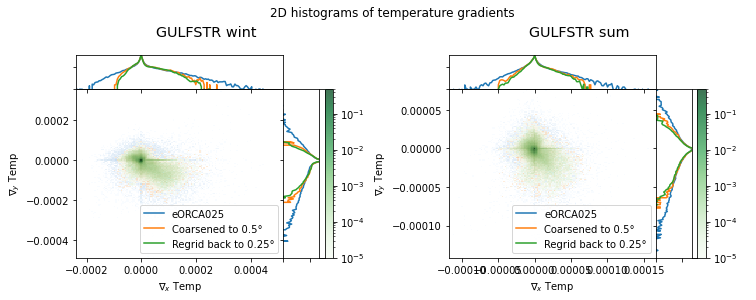

In [33]:
name_hist = 'hist_temp_grad_2D'
x = 'gradx_temp_bin'
y = 'grady_temp_bin'

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
fig.suptitle('2D histograms of temperature gradients')
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 2, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for subfig_index, region in enumerate([0,1]) :
    subfigs[subfig_index].suptitle(data[region]['label'], fontsize='x-large')
    sel_data0 = hists[region]['LR'][name_hist]
    sel_data1 = hists[region]['LR_mod'][0][name_hist]
    sel_data2 = hists[region]['Regrid_LR_mod'][0][name_hist]
    big_ax = subfigs[subfig_index].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[subfig_index].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[subfig_index].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[subfig_index].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])

    margin_hist(sel_data0, 0, x, y, top_ax, right_ax, big_ax)
    hist_joint = margin_hist(sel_data1, 1, x, y, top_ax, right_ax, big_ax)
    hist_joint = margin_hist(sel_data2, 2, x, y, top_ax, right_ax, big_ax)
    big_ax.set(xlabel=r'$\nabla_x$ Temp', ylabel=r'$\nabla_y$ Temp')
    big_ax.legend(handles=top_ax.lines, labels=['eORCA025', 'Coarsened to 0.5°', 'Regrid back to 0.25°'], loc='lower right')

    subfigs[subfig_index].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)

plt.show()

### Salinity

In [34]:
%%time
name_hist = 'hist_sal_grad_2D'
x = 'gradx_sal'
y = 'grady_sal'
for i in range(len(data)) :
    # reference histogram
    ref_case = 0
    ref_hist = compute_2D_histogram(data[i]['LR'], x, y, nb_of_bins).compute()
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for dataKey in ['LR'] :
        hists[i][dataKey][name_hist] = compute_2D_histogram(data[i][dataKey], x, y, nb_of_bins, bins=bins).compute()
    for filtered_quantity in ['LR_mod', 'Regrid_LR_mod'] :
        for ifilter in range(len(filters)) :
            hists[i][filtered_quantity][ifilter][name_hist] = compute_2D_histogram(data[i][filtered_quantity][ifilter], \
                                                                           x, y, nb_of_bins, bins=bins).compute()

CPU times: user 2.43 s, sys: 87.4 ms, total: 2.51 s
Wall time: 8.24 s


### Joint temperature and salinity

In [35]:
%%time
name_hist = 'hist_temp_sal_sqr'
# x = 'temp_second_deriv'
# y = 'sal_second_deriv'
x='grad_temp_sqr'
y='grad_sal_sqr'

for i in range(len(data)) :
    # reference histogram
    ref_case = 0
    ref_hist = compute_2D_histogram(data[i]['LR'], x, y, nb_of_bins).compute()
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for dataKey in ['LR'] :
        hists[i][dataKey][name_hist] = compute_2D_histogram(data[i][dataKey], x, y, nb_of_bins, bins=bins).compute()
    for filtered_quantity in ['LR_mod', 'Regrid_LR_mod'] :
        for ifilter in range(len(filters)) :
            hists[i][filtered_quantity][ifilter][name_hist] = compute_2D_histogram(data[i][filtered_quantity][ifilter].chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}), \
                                                                           x, y, nb_of_bins, bins=bins).compute()

CPU times: user 3.06 s, sys: 81.9 ms, total: 3.14 s
Wall time: 7.68 s


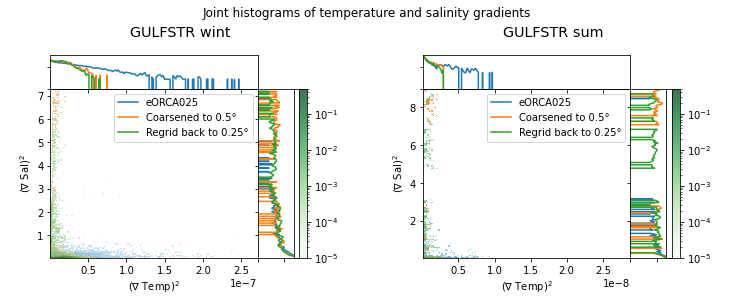

In [36]:
name_hist = 'hist_temp_sal_sqr'
x = 'grad_temp_sqr_bin'
y = 'grad_sal_sqr_bin'

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
fig.suptitle('Joint histograms of temperature and salinity gradients')
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 2, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for subfig_index, region in enumerate([0,1]) :
    subfigs[subfig_index].suptitle(data[region]['label'], fontsize='x-large')
    sel_data0 = hists[region]['LR'][name_hist]
    sel_data1 = hists[region]['LR_mod'][0][name_hist]
    sel_data2 = hists[region]['Regrid_LR_mod'][0][name_hist]
    big_ax = subfigs[subfig_index].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[subfig_index].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[subfig_index].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[subfig_index].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])

    margin_hist(sel_data0, 0, x, y, top_ax, right_ax, big_ax)
    hist_joint = margin_hist(sel_data1, 1, x, y, top_ax, right_ax, big_ax)
    hist_joint = margin_hist(sel_data2, 2, x, y, top_ax, right_ax, big_ax)
    big_ax.set(xlabel=r'($\nabla$ Temp)$^2$', ylabel=r'($\nabla$ Sal)$^2$')
    big_ax.legend(handles=top_ax.lines, labels=['eORCA025', 'Coarsened to 0.5°', 'Regrid back to 0.25°'], loc='upper right')

    subfigs[subfig_index].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)

plt.show()

# Distances between histograms

## KL divergence

Kullback-Leibler (KL) divergence (or relative entropy) 
$$ D_{KL} (P || Q) = \sum_i P(i) \log\frac{P(i)}{Q(i)} $$
a measure of how one probability distribution $Q$ is different from a second, reference probability distribution $P$ (information gain of $P$ in comparison to $Q$). In other words, it is the amount of information lost when $Q$ is used to approximate $P$.

In [37]:
def D_KL(hist_P, hist_Q) :
    masked_P = np.where(hist_P >0, hist_P, np.NaN)
    masked_Q = np.where(hist_Q >0, hist_Q, np.NaN)
    return np.nansum(masked_P*(np.log(masked_P/masked_Q)))

Symmertrized KL divergence (Jeffreys divergence):
$$ D_{sym} (P || Q) = D_{KL} (P || Q) + D_{KL} (Q || P) $$

In [38]:
def D_sym(hist_P, hist_Q) :
    return D_KL(hist_P, hist_Q)+D_KL(hist_Q, hist_P)

## B-distrance

- Bhattacharyya distance (to estimate overlap between two distributions):
$$ D_B(P,Q) = -\log[BC(P,Q)] $$
$$ BC(P,Q) = \sum_i \sqrt{P(i) Q(i)} $$
- Helliger distance:
$$D_H (P,Q) = \sqrt{1-BC(P,Q)}$$ 
is limited $0<D_H (P,Q)<1$ 

In [39]:
def BC(hist_P, hist_Q) :
    return np.nansum(np.sqrt(hist_P*hist_Q))

def D_H(hist_P, hist_Q) :
    return np.sqrt(1.-BC(hist_P,hist_Q))

def D_B(hist_P, hist_Q) :
    BC_val = BC(hist_P,hist_Q)
    if (BC_val > 0) :
        return -np.log(BC_val)
    else:
        return 0.

## Bar plots of distances

### 2D histograms of salinity gradients

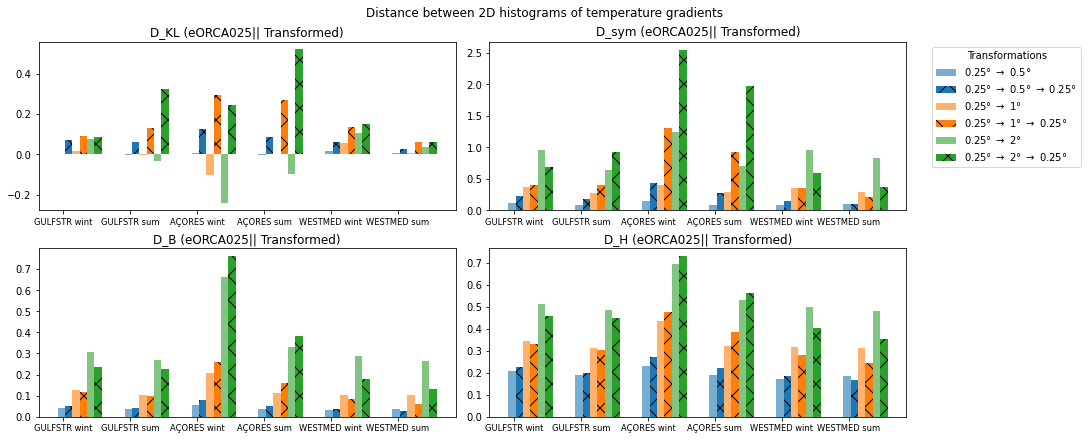

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(15, 6))
fig.suptitle('Distance between 2D histograms of temperature gradients')
name_hist = 'hist_temp_grad_2D'
ref_dataKey = 'LR'
x = np.arange(len(data))
bar_width = 0.11
distances = [D_KL, D_sym, D_B, D_H]
for i_distance, i_ax in enumerate(np.ndindex(2, 2)):
    for ifilter in range(len(filters)) :
        ax[i_ax].bar(x+(2*ifilter+1)*bar_width, [distances[i_distance](hists[region][ref_dataKey][name_hist], hists[region]['LR_mod'][ifilter][name_hist]) for region in range(len(data))], \
                  color=line_colors[ifilter], width=bar_width, alpha=0.6, label=filters[ifilter]['label'])
#         ax[1].bar(x+(2*ifilter+1)*bar_width, [D_sym(hists[region][ref_dataKey][name_hist], hists[region]['LR_mod'][ifilter][name_hist]) for region in range(len(data))], \
#                   width=bar_width, color=line_colors[ifilter], alpha=0.6, label=filters[ifilter]['label'])
        ax[i_ax].bar(x+(2*ifilter+2)*bar_width, [distances[i_distance](hists[region][ref_dataKey][name_hist], hists[region]['Regrid_LR_mod'][ifilter][name_hist]) for region in range(len(data))], \
                  color=line_colors[ifilter], width=bar_width, hatch='x', label=filters[ifilter]['label']+r' $\rightarrow$ 0.25°')
#         ax[1].bar(x+(2*ifilter+2)*bar_width, [D_sym(hists[region][ref_dataKey][name_hist], hists[region]['Regrid_LR_mod'][ifilter][name_hist]) for region in range(len(data))], \
#                   color=line_colors[ifilter], width=bar_width, hatch='x', label=filters[ifilter]['label']+r' $\rightarrow$ 0.25°')
    ax[i_ax].set_xticks(x + 1.25*bar_width)
    ax[i_ax].set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    ax[i_ax].xaxis.set_tick_params(labelsize='small')
    ax[i_ax].set(title=distances[i_distance].__name__+' (eORCA025|| Transformed)')
    ax[i_ax].set(yscale='linear')
ax[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Transformations')    
plt.show()

### 2D histograms of temperature gradients

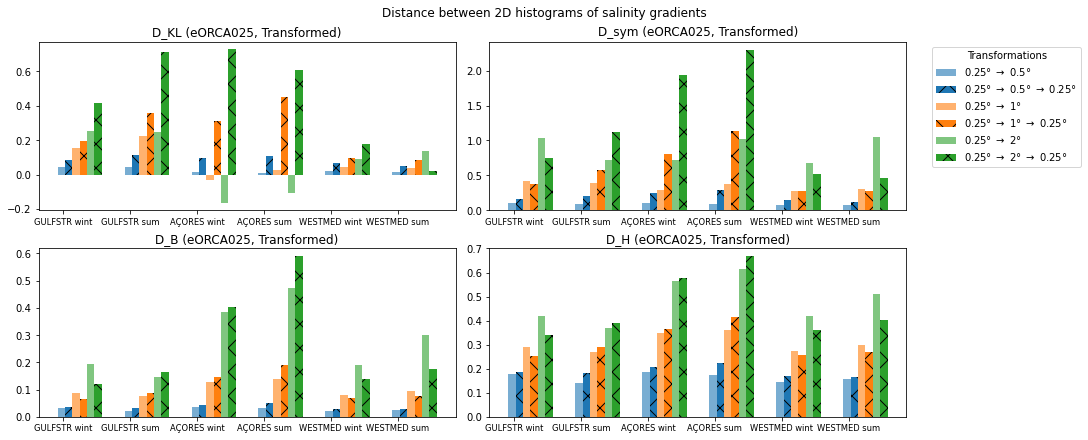

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(15, 6))
fig.suptitle('Distance between 2D histograms of salinity gradients')
name_hist = 'hist_sal_grad_2D'
ref_dataKey = 'LR'
x = np.arange(len(data))
bar_width = 0.11
distances = [D_KL, D_sym, D_B, D_H]
for i_distance, i_ax in enumerate(np.ndindex(2, 2)):
    for ifilter in range(len(filters)) :
        ax[i_ax].bar(x+(2*ifilter+1)*bar_width, [distances[i_distance](hists[region][ref_dataKey][name_hist], hists[region]['LR_mod'][ifilter][name_hist]) for region in range(len(data))], \
                  color=line_colors[ifilter], width=bar_width, alpha=0.6, label=filters[ifilter]['label'])
        ax[i_ax].bar(x+(2*ifilter+2)*bar_width, [distances[i_distance](hists[region][ref_dataKey][name_hist], hists[region]['Regrid_LR_mod'][ifilter][name_hist]) for region in range(len(data))], \
                  color=line_colors[ifilter], width=bar_width, hatch='x', label=filters[ifilter]['label']+r' $\rightarrow$ 0.25°')
    ax[i_ax].set_xticks(x + 1.25*bar_width)
    ax[i_ax].set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    ax[i_ax].xaxis.set_tick_params(labelsize='small')
    ax[i_ax].set(title=distances[i_distance].__name__+' (eORCA025, Transformed)')
    ax[i_ax].set(yscale='linear')
ax[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Transformations')    
plt.show()

### Joint histograms of $(\nabla T)^2$ and $(\nabla S)^2$

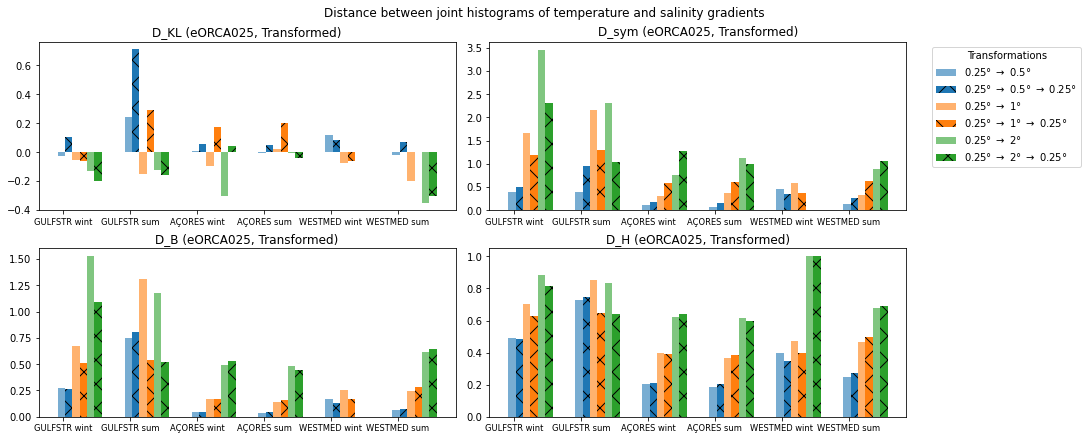

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(15, 6))
fig.suptitle('Distance between joint histograms of temperature and salinity gradients')
name_hist = 'hist_temp_sal_sqr'
ref_dataKey = 'LR'
x = np.arange(len(data))
bar_width = 0.11
distances = [D_KL, D_sym, D_B, D_H]
for i_distance, i_ax in enumerate(np.ndindex(2, 2)):
    for ifilter in range(len(filters)) :
        ax[i_ax].bar(x+(2*ifilter+1)*bar_width, [distances[i_distance](hists[region][ref_dataKey][name_hist], hists[region]['LR_mod'][ifilter][name_hist]) for region in range(len(data))], \
                  color=line_colors[ifilter], width=bar_width, alpha=0.6, label=filters[ifilter]['label'])
        ax[i_ax].bar(x+(2*ifilter+2)*bar_width, [distances[i_distance](hists[region][ref_dataKey][name_hist], hists[region]['Regrid_LR_mod'][ifilter][name_hist]) for region in range(len(data))], \
                  color=line_colors[ifilter], width=bar_width, hatch='x', label=filters[ifilter]['label']+r' $\rightarrow$ 0.25°')
    ax[i_ax].set_xticks(x + 1.25*bar_width)
    ax[i_ax].set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    ax[i_ax].xaxis.set_tick_params(labelsize='small')
    ax[i_ax].set(title=distances[i_distance].__name__+' (eORCA025, Transformed)')
    ax[i_ax].set(yscale='linear')
ax[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Transformations')    
plt.show()

# Conclusions

- The Helliger distance $D_H$ appears to be optimal for comparison, as it is limited between 0 and 1, does not require choosing reference distribution
- As expected, in general, the distances between histograms of not-coarsed and coarsed fields increase with the size of coarsening window.
- Performing reinterpolation (regridding) back to the original resolution of 0.25° reduces the distance or keeps it the same